## Select one ETF which represents each of the following asset classes:
1. U.S. Market
2. International Market (ex-U.S.)
3. U.S. Bonds
4. International Bonds (ex-U.S.)
5. Other Asset Class (of your choice, such as Commodities)


For each ETF download the daily values from 12/31/2011 to 12/31/2021.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_excel('AM HW 3 ETFs.xlsx')

In [4]:
df['Year'] = df.Date.dt.year

V = df[['VTHR','Year','Date']]
A = df[['ACWX','Year','Date']]
G = df[['GLD','Year','Date']]
I = df[['IBND','Year','Date']]
S = df[['SHY','Year','Date']]
objs = [V,A,G,I,S]

df.head()

,Date,VTHR,ACWX,GLD,IBND,SHY,Year
0,2012-01-03,58.259998,37.709999,155.919998,32.009998,84.449997,2012
1,2012-01-04,58.169998,37.490002,156.710007,31.490000,84.459999,2012
2,2012-01-05,58.380001,37.060001,157.779999,31.200001,84.470001,2012
3,2012-01-06,58.240002,36.570000,157.199997,31.040001,84.459999,2012
4,2012-01-09,58.419998,36.900002,156.500000,31.379999,84.480003,2012


### For each asset class, calculate the annualized returns, annualized standard deviation, Sharpe ratio (assume risk-free rate is zero), maximum drawdown

In [5]:
# ANNUALIZED RETURNS
def annualized_ret(series,N):
    ret = (series.iloc[-1]/series.iloc[0])
    return (1+ret) ** (1/N) - 1
for df_ in objs:
    col = df_.columns[0]
    returns = annualized_ret(df_[col], df_.Year.max()-df_.Year.min())
    print('Annualized return for', col, '{:.2%}'.format(returns))

Annualized return for VTHR 18.77%
Annualized return for ACWX 10.59%
Annualized return for GLD 8.57%
Annualized return for IBND 8.48%
Annualized return for SHY 8.08%


In [6]:
# ANNUALIZED STANDARD DEVIATION
def annualized_std(series,N):
    return series.std()/np.sqrt(N)

for df_ in objs:
    col = df_.columns[0]
    sds = annualized_std(df_[col], df_.Year.max()-df_.Year.min())
    print('Annualized standard deviation for', col, '{:.4f}'.format(sds))

Annualized standard deviation for VTHR 12.6326
Annualized standard deviation for ACWX 1.7296
Annualized standard deviation for GLD 7.4090
Annualized standard deviation for IBND 0.6471
Annualized standard deviation for SHY 0.2922


In [7]:
# SHARPE RATIO
for df_ in objs:
    col = df_.columns[0]
    N = df_.Year.max()-df_.Year.min()
    #returns = annualized_ret(df_[col], N)
    returns = (df_[col].iloc[-1] - df_[col].iloc[0])/df_[col].iloc[0]
    sds = annualized_std(df_[col], N)
    print('Sharpe ratio for', col, '{:.4f}'.format(returns/sds))

Sharpe ratio for VTHR 0.2139
Sharpe ratio for ACWX 0.2743
Sharpe ratio for GLD 0.0130
Sharpe ratio for IBND 0.1246
Sharpe ratio for SHY 0.0442


In [8]:
# MAX DRAWDOWN
for df_ in objs:
    col = df_.columns[0]
    s = df_[col]
    drawdown = (s.min()-s.max()) / s.max()
    print('Maximum drawdown for', col, '{:.4f}'.format(drawdown))

Maximum drawdown for VTHR -0.7318
Maximum drawdown for ACWX -0.4454
Maximum drawdown for GLD -0.4817
Maximum drawdown for IBND -0.2403
Maximum drawdown for SHY -0.0455


### For each asset class, plot the accumulated performance over time assuming one invests \$100 on 12/31/2011

In [9]:
def plot_performance(df, cash0):
    temp = df.copy()
    col = temp.columns[0]
    temp['daily_return'] = (temp[col] / temp[col].shift(1)) - 1
    temp['cum_return'] = (1+temp.daily_return).cumprod() - 1
    temp['returns'] = cash0 * (1+temp.cum_return)
    plt.plot(temp.Date, temp.returns, label=col)
    plt.legend()
    plt.title('Accumulated Performance Over Time')

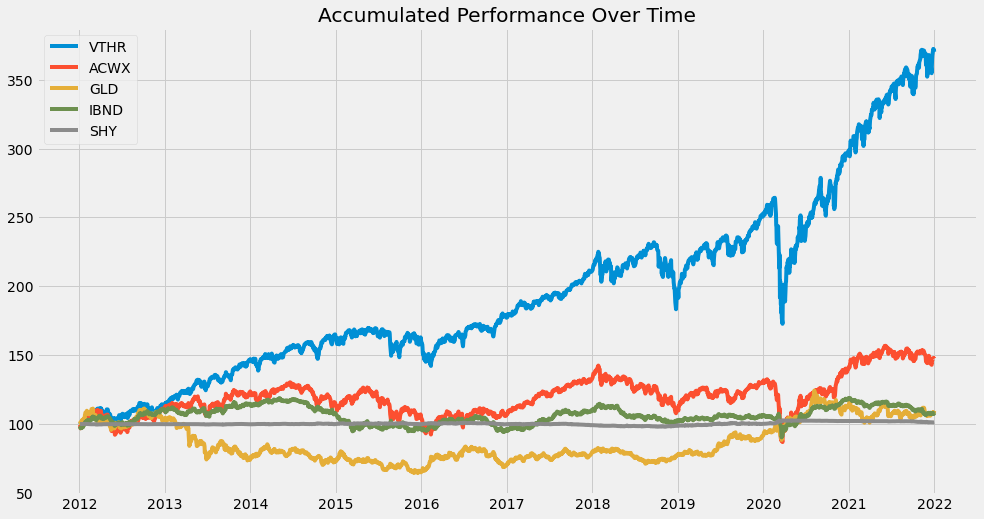

In [10]:
plt.figure(figsize=(15,8))
for df_ in objs:
    plot_performance(df_,100)
plt.show()

### Rebalance the portfolio monthly and want to measure the daily performance. Said differently, at the end of each month the portfolio is reset back to the target weights. During the month, the weights of each asset classes change due to the asset classes’ unique performance and the portfolio’s performance. The target weights for each asset class are the following

1. *VTHR* U.S. Market 30%
2. *ACWX* International Market (ex-U.S.) 25%
3. *SHY* U.S. Bonds 20%
4. *IBND* International Bonds (ex-U.S.) 15%
5. *GLD* Other Asset Class (of your choice, such as Commodities) 10%

In [12]:
df_reb_dates = df[(df['Date'].dt.month).isin([x for x in range(1,13)])][['Date']]\
                    .groupby([df['Date'].dt.year, df['Date'].dt.month]).max()

In [13]:
lst_date_stock = df[['Date']].sort_values(by='Date').drop_duplicates().reset_index(drop=True)

In [14]:
CF0 = 1000
weight = [0.3,0.25,0.2,0.15,0.1]  # target weight
initial = [x*CF0 for x in weight]
df3 = df.copy().drop(columns='Year')
assets = df3.columns.to_list()[1:]
j = 0
res = df3[['Date']]
for name in assets:
    res[name] = 0

In [15]:
for row in range(len(res)):
    if row == 0:
        res.iloc[row,1:] = np.nan  # first day of investing
    else:
        if row == 1:  # first day of getting returns
            for asset in assets:
                return_daily = (df3.loc[row, asset]/df3.loc[row-1,asset]) - 1
                cum_return = (1+return_daily).cumprod() - 1
                res.loc[row,asset] = initial[assets.index(asset)] * (1+cum_return)
        else:
            if res.iloc[row,0] == df_reb_dates.iloc[j][0]:  # need to rebalance
                total = res.iloc[row-1,1:].sum()
                res.iloc[row, 1:] = [x*total for x in weight]
                j += 1
            else:  # all other general cases
                for asset in assets:
                    return_daily = (df3.loc[row, asset]/df3.loc[row-1,asset]) - 1
                    cum_return = (1+return_daily).cumprod() - 1
                    res.loc[row,asset] = res.loc[row-1,asset] * (1+cum_return)

In [16]:
test = res.iloc[[17,18,19,20,21,30]]  # just to check if the rebalance works
test['total'] = test.sum(axis=1)
test

,Date,VTHR,ACWX,GLD,IBND,SHY,total
17,2012-01-27,311.380036,260.607280,216.739358,151.733847,100.177621,1040.638142
18,2012-01-30,309.732256,257.756577,215.533608,152.952207,100.142099,1036.116748
19,2012-01-31,310.835024,259.029187,207.223350,155.417512,103.611675,1036.116748
20,2012-02-01,314.561308,263.069274,207.529332,156.084331,103.538168,1044.782412
21,2012-02-02,315.648159,263.996507,209.352991,155.941450,103.550413,1048.489520
30,2012-02-15,319.529715,265.850960,205.754639,155.750924,103.452407,1050.338645


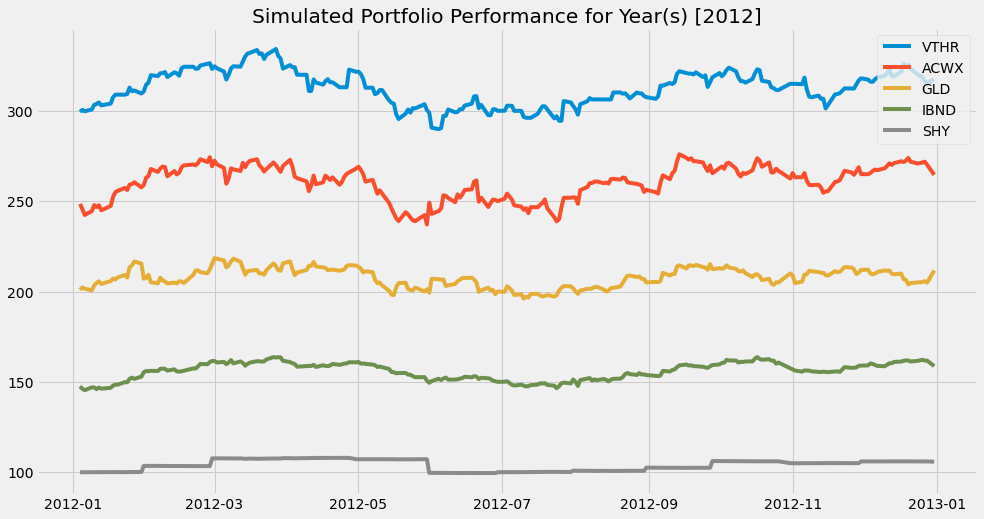

In [17]:
plt.figure(figsize=(15,8))
yr = [2012]  # can add values to see different results
year_range = res[res.Date.dt.year.isin(yr)]
for col in year_range.columns[1:]:
    plt.plot(year_range.Date, year_range[col], label=col)
plt.title('Simulated Portfolio Performance for Year(s) {}'.format(yr))
plt.legend()
plt.show()

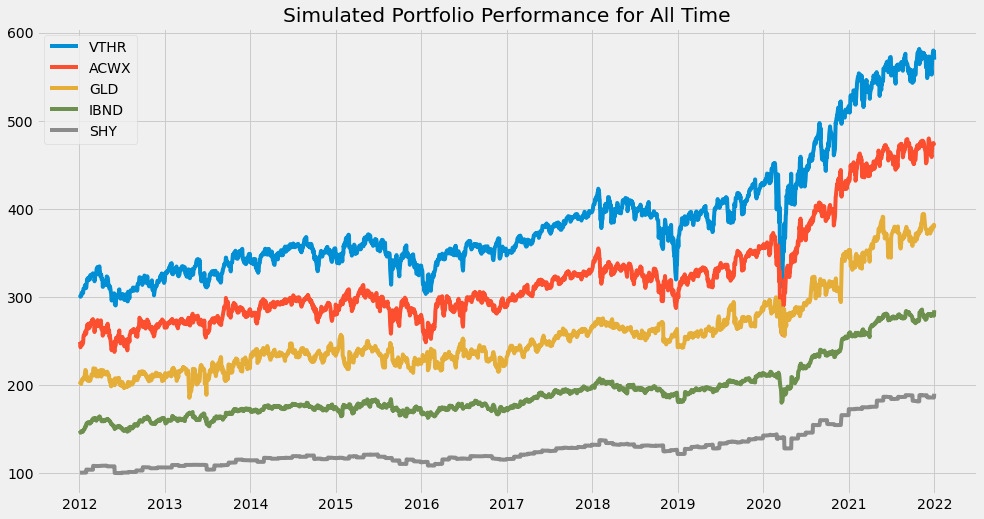

In [19]:
plt.figure(figsize=(15,8))
for col in res.columns[1:]:
    plt.plot(res.Date, res[col], label=col)
plt.title('Simulated Portfolio Performance for All Time')
plt.legend()
plt.show()

In [21]:
rebalance_changes = res.copy().set_index('Date').pct_change()[2:]
rebalance_changes

,VTHR,ACWX,GLD,IBND,SHY
Date,,,,,
2012-01-05,0.003610,-0.011470,0.006828,-0.009209,0.000118
2012-01-06,-0.002398,-0.013222,-0.003676,-0.005128,-0.000118
2012-01-09,0.003091,0.009024,-0.004453,0.010954,0.000237
2012-01-10,0.008730,0.013550,0.013674,-0.000637,0.000118
2012-01-11,0.001527,-0.004546,0.006493,-0.006378,0.000355
...,...,...,...,...,...
2021-12-27,0.012651,0.005949,0.002367,-0.000869,-0.000351
2021-12-28,-0.002074,0.000179,-0.004310,-0.001160,0.000000
2021-12-29,0.000739,-0.002688,-0.000297,0.002032,-0.000117


In [22]:
metric = pd.DataFrame(columns=rebalance_changes.columns.to_list(), index=['Annualized Return',\
                                                                'Annualized Standatd Deviation',\
                                                                'Sharpe Ratio',\
                                                                'Maximum Drawdown'])
for col in rebalance_changes.columns.to_list():
    return_series = rebalance_changes[col].iloc[1:]
    value_series = res[col].iloc[1:]
    
    N = res.Date.dt.year.max()-res.Date.dt.year.min()
    
    ann_ret = annualized_ret(value_series,N)
    ann_std = annualized_std(return_series,N)
    sharpe = (return_series.mean()/ann_std)
    drawdown = (value_series.min() - value_series.max())/value_series.max()
    
    metric.loc['Annualized Return',col] = ann_ret
    metric.loc['Annualized Standatd Deviation',col] = ann_std
    metric.loc['Sharpe Ratio',col] = sharpe
    metric.loc['Maximum Drawdown',col] = drawdown
    
metric

,VTHR,ACWX,GLD,IBND,SHY
Annualized Return,0.125588,0.125941,0.125048,0.126808,0.125452
Annualized Standatd Deviation,0.003669,0.003832,0.004132,0.002226,0.001958
Sharpe Ratio,0.085776,0.085644,0.079087,0.129021,0.138812
Maximum Drawdown,-0.501206,-0.505443,-0.529991,-0.490198,-0.475237


### Using the same five asset classes, find the portfolio with the maximum Sharpe ratio, from 12/31/2011 to 12/31/2021. Assume that no asset class within the portfolio can be greater than 45%. Find the weights of each asset class in the maximum Sharpe ratio portfolio. Using those weights and the simulation engine that you created, construct another simulated portfolio from 12/31/2011 to 12/31/2021. Plot its accumulated performance over the same time period, and table the same metrics you previously showed.

Assumptions:
+ no rebalance to aforementioned weights
+ only rebalance if certain asset has a weight over 45%
+ start with equal weights (20%)

In [23]:
CF0 = 1000
initial = [CF0/5] * 5

df4 = df.copy().drop(columns='Year')
assets = df4.columns.to_list()[1:]
j = 0
threshold = 0.45

res2 = df4[['Date']]
res3 = res2.copy()   # this data frame is for returns and weights to calculate sharpe ratios
for name in assets:
    res2[name] = 0
    res3[name] = 0
    
    colname_w = 'weight_' + asset
    res3[colname_w] = 0
    
    
for row in range(len(res2)):
    if row == 0:
        res2.iloc[row,1:] = np.nan  # first day of investing
    else:
        if row == 1:  # first day of getting returns
            for asset in assets:
                return_daily = (df4.loc[row, asset]/df4.loc[row-1,asset]) - 1
                cum_return = (1+return_daily).cumprod() - 1
                res2.loc[row,asset] = initial[assets.index(asset)] * (1+cum_return)
    
                res3.loc[row,asset] = return_daily
        
            total = res2.iloc[row,1:].sum()
            for asset in assets:
                colname_w = 'weight_' + asset
                res3.loc[row,colname_w] = res2.loc[row, asset]/total
                
        else:
            rebalance = False
            total = res2.iloc[row-1,1:].sum()
            for asset in assets:
                val = res2.loc[row-1,asset]
                if val > (total * threshold):  # rebalance
                    print(asset, val, res2.iloc[row-1,0])  # if need to rebalance, print the asset, value, and date
                    rebalance = True
                    break
                    
            if rebalance:
                res2.iloc[row, 1:] = total/5
                reba_dates.append(res2.iloc[row,0])
                
            else:
                for asset in assets:
                    return_daily = (df4.loc[row, asset]/df4.loc[row-1,asset]) - 1
                    cum_return = (1+return_daily).cumprod() - 1
                    res2.loc[row,asset] = res2.loc[row-1,asset] * (1+cum_return)
                    
                    res3.loc[row,asset] = return_daily
                    
                total = res2.iloc[row,1:].sum()  
                for asset in assets:
                    colname_w = 'weight_' + asset
                    res3.loc[row,colname_w] = res2.loc[row, asset]/total

In [24]:
df5 = res3.iloc[1:,:].set_index('Date')
df5['portfolio_return'] = (df5.VTHR*df5.weight_VTHR)+(df5.ACWX*df5.weight_ACWX)+(df5.GLD*df5.weight_GLD)+(df5.IBND*df5.weight_IBND)+(df5.SHY*df5.weight_SHY)
df5

,VTHR,weight_SHY,ACWX,GLD,IBND,SHY,weight_VTHR,weight_ACWX,weight_GLD,weight_IBND,portfolio_return
Date,,,,,,,,,,,
2012-01-04,-0.001545,0.200764,-0.005834,0.005067,-0.016245,0.000118,0.200430,0.199569,0.201757,0.197479,-0.003636
2012-01-05,0.003610,0.201187,-0.011470,0.006828,-0.009209,0.000118,0.201553,0.197672,0.203538,0.196049,-0.001932
2012-01-06,-0.002398,0.202148,-0.013222,-0.003676,-0.005128,-0.000118,0.202055,0.196014,0.203784,0.195999,-0.004854
2012-01-09,0.003091,0.201455,0.009024,-0.004453,0.010954,0.000237,0.201936,0.197057,0.202132,0.197420,0.003712
2012-01-10,0.008730,0.200059,0.013550,0.013674,-0.000637,0.000118,0.202264,0.198321,0.203453,0.195904,0.007134
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.012651,0.120837,0.005949,0.002367,-0.000869,-0.000351,0.444357,0.176588,0.129634,0.128585,0.006825
2021-12-28,-0.002074,0.121030,0.000179,-0.004310,-0.001160,0.000000,0.444145,0.176902,0.129281,0.128641,-0.001596
2021-12-29,0.000739,0.121009,-0.002688,-0.000297,0.002032,-0.000117,0.444446,0.176416,0.129235,0.128895,0.000064


In [25]:
asset = ['VTHR','ACWX','IBND','SHY','GLD']
weight = ['weight_' + x for x in asset]
covariance_mat = df5[asset].cov()
covariance_mat

,VTHR,ACWX,IBND,SHY,GLD
VTHR,0.000100,0.000089,5.717082e-06,-1.557817e-06,0.000002
ACWX,0.000089,0.000114,1.517965e-05,-1.294338e-06,0.000012
IBND,0.000006,0.000015,2.854352e-05,8.243752e-07,0.000020
SHY,-0.000002,-0.000001,8.243752e-07,3.498309e-07,0.000002
GLD,0.000002,0.000012,1.987075e-05,1.668268e-06,0.000090


In [26]:
df5['portfolio_std'] = 0

In [27]:
for idx, row in df5.iterrows():
    weight_vec = row[weight].values
    df5.loc[idx,'portfolio_std'] = np.sqrt(weight_vec.T @ covariance_mat @ weight_vec)
    
df5.head()

,VTHR,weight_SHY,ACWX,GLD,IBND,SHY,weight_VTHR,weight_ACWX,weight_GLD,weight_IBND,portfolio_return,portfolio_std
Date,,,,,,,,,,,,
2012-01-04,-0.001545,0.200764,-0.005834,0.005067,-0.016245,0.000118,0.200430,0.199569,0.201757,0.197479,-0.003636,0.004985
2012-01-05,0.003610,0.201187,-0.011470,0.006828,-0.009209,0.000118,0.201553,0.197672,0.203538,0.196049,-0.001932,0.004982
2012-01-06,-0.002398,0.202148,-0.013222,-0.003676,-0.005128,-0.000118,0.202055,0.196014,0.203784,0.195999,-0.004854,0.004971
2012-01-09,0.003091,0.201455,0.009024,-0.004453,0.010954,0.000237,0.201936,0.197057,0.202132,0.197420,0.003712,0.004976
2012-01-10,0.008730,0.200059,0.013550,0.013674,-0.000637,0.000118,0.202264,0.198321,0.203453,0.195904,0.007134,0.004992


In [28]:
df5['sharpe_ratio'] = df5.portfolio_return/df5.portfolio_std
df5.head()

,VTHR,weight_SHY,ACWX,GLD,IBND,SHY,weight_VTHR,weight_ACWX,weight_GLD,weight_IBND,portfolio_return,portfolio_std,sharpe_ratio
Date,,,,,,,,,,,,,
2012-01-04,-0.001545,0.200764,-0.005834,0.005067,-0.016245,0.000118,0.200430,0.199569,0.201757,0.197479,-0.003636,0.004985,-0.729346
2012-01-05,0.003610,0.201187,-0.011470,0.006828,-0.009209,0.000118,0.201553,0.197672,0.203538,0.196049,-0.001932,0.004982,-0.387734
2012-01-06,-0.002398,0.202148,-0.013222,-0.003676,-0.005128,-0.000118,0.202055,0.196014,0.203784,0.195999,-0.004854,0.004971,-0.976462
2012-01-09,0.003091,0.201455,0.009024,-0.004453,0.010954,0.000237,0.201936,0.197057,0.202132,0.197420,0.003712,0.004976,0.746121
2012-01-10,0.008730,0.200059,0.013550,0.013674,-0.000637,0.000118,0.202264,0.198321,0.203453,0.195904,0.007134,0.004992,1.428992


In [29]:
optimized_portfolio = df5[df5.sharpe_ratio == df5.sharpe_ratio.max()]
optimized_portfolio[weight]

,weight_VTHR,weight_ACWX,weight_IBND,weight_SHY,weight_GLD
Date,,,,,
2020-03-24,0.326617,0.16363,0.161263,0.177724,0.170767


In [30]:
w = optimized_portfolio[weight].values.flatten().tolist()
w

[0.32661675071806245,
 0.16362987142028207,
 0.16126303696578392,
 0.17772369857238313,
 0.1707666423234884]

In [31]:
CF0 = 1000
initial = [x*CF0 for x in w]
df6 = df.copy().drop(columns='Year')
assets = df6.columns.to_list()[1:]
j = 0
res4 = df6[['Date']]
for name in assets:
    res4[name] = 0

In [32]:
for row in range(len(res)):
    if row == 0:
        res4.iloc[row,1:] = np.nan  # first day of investing
    else:
        if row == 1:  # first day of getting returns
            for asset in assets:
                return_daily = (df6.loc[row, asset]/df6.loc[row-1,asset]) - 1
                cum_return = (1+return_daily).cumprod() - 1
                res4.loc[row,asset] = initial[assets.index(asset)] * (1+cum_return)
        else:
            for asset in assets:
                return_daily = (df6.loc[row, asset]/df6.loc[row-1,asset]) - 1
                cum_return = (1+return_daily).cumprod() - 1
                res4.loc[row,asset] = res4.loc[row-1,asset] * (1+cum_return)

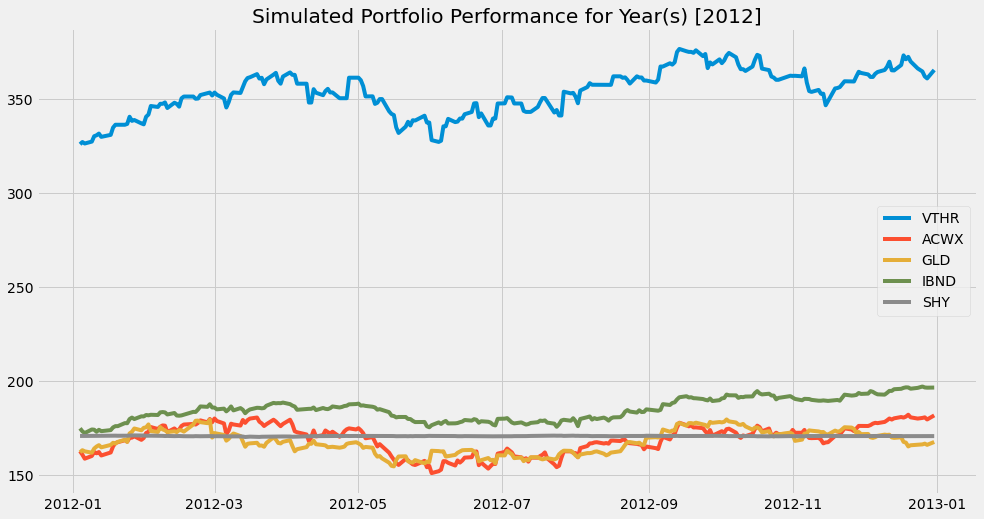

In [33]:
plt.figure(figsize=(15,8))
yr = [2012]   # can add values to see different results
year_range = res4[res4.Date.dt.year.isin(yr)]
for col in year_range.columns[1:]:
    plt.plot(year_range.Date, year_range[col], label=col)
plt.title('Simulated Portfolio Performance for Year(s) {}'.format(yr))
plt.legend()
plt.show()

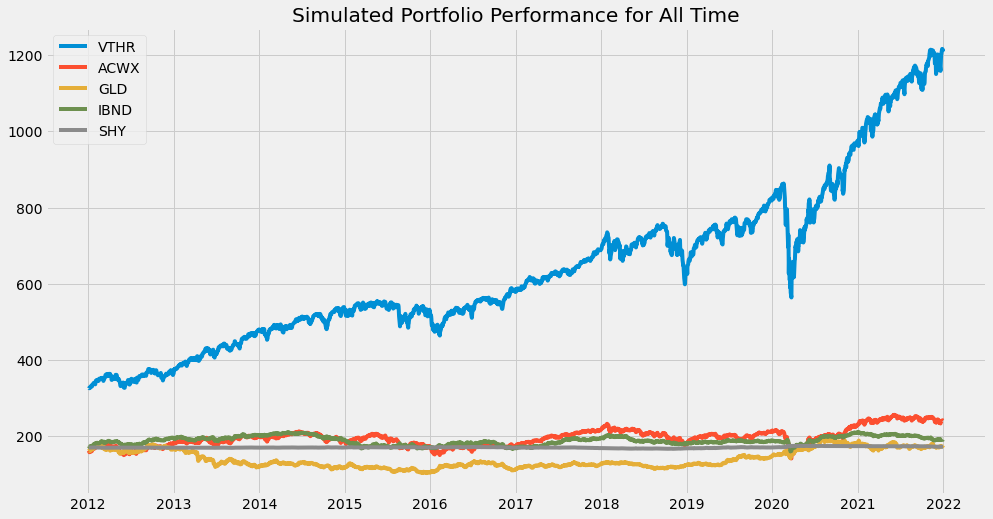

In [34]:
plt.figure(figsize=(15,8))
for col in res4.columns[1:]:
    plt.plot(res4.Date, res4[col], label=col)
plt.title('Simulated Portfolio Performance for All Time')
plt.legend()
plt.show()

In [35]:
pct_change = res4.copy().set_index('Date').pct_change()[2:]

In [36]:
metric = pd.DataFrame(columns=pct_change.columns.to_list(), index=['Annualized Return',\
                                                                'Annualized Standatd Deviation',\
                                                                'Sharpe Ratio',\
                                                                'Maximum Drawdown'])
for col in pct_change.columns.to_list():
    return_series = pct_change[col].iloc[1:]
    value_series = res4[col].iloc[1:]
    N = res4.Date.dt.year.max()-res4.Date.dt.year.min()
    
    ann_ret = annualized_ret(value_series,N)
    ann_std = annualized_std(return_series,N)
    sharpe = (return_series.mean()/ann_std)
    drawdown = (value_series.min() - value_series.max())/value_series.max()
    
    metric.loc['Annualized Return',col] = ann_ret
    metric.loc['Annualized Standatd Deviation',col] = ann_std
    metric.loc['Sharpe Ratio',col] = sharpe
    metric.loc['Maximum Drawdown',col] = drawdown
    
metric

,VTHR,ACWX,GLD,IBND,SHY
Annualized Return,0.187857,0.106337,0.085409,0.085841,0.080825
Annualized Standatd Deviation,0.003335,0.003564,0.003163,0.001777,0.000197
Sharpe Ratio,0.171,0.061458,0.024366,0.031085,0.026274
Maximum Drawdown,-0.731849,-0.445384,-0.481665,-0.240284,-0.045507
